# Preparing the Dataset

In [1]:
# Importing Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

In [2]:
import os
import zipfile

# Uploading Kaggle API Key
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Creating the .kaggle directory if it does not exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Moving the uploaded kaggle.json file to the correct directory
!mv /content/kaggle.json /root/.kaggle/

# Downloading the Dataset
!kaggle datasets download -d prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

# Unzipping the dataset
with zipfile.ZipFile('/content/cervical-cancer-largest-dataset-sipakmed.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/si_pak_med')

mv: cannot stat '/content/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed
License(s): other
100% 6.40G/6.40G [00:31<00:00, 275MB/s]
100% 6.40G/6.40G [00:31<00:00, 220MB/s]


# Image Preprocessing

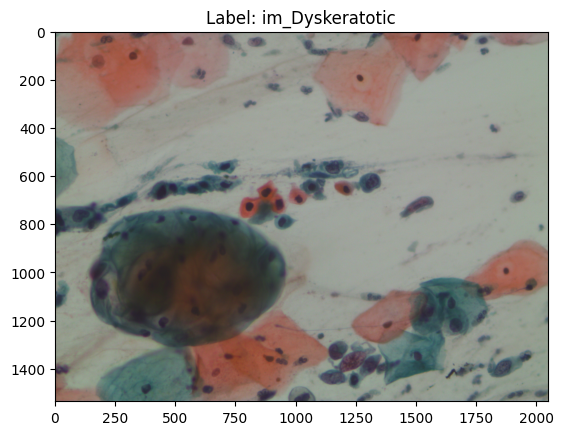

Image Size: (2048, 1536)


In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Loading dataset without transformations for inspection
raw_dataset = datasets.ImageFolder(root='/content/si_pak_med')

# Function to show sample image and size
def show_sample_image(dataset, index):
    image, label = dataset[index]
    plt.imshow(image)  # Directly showing PIL image
    plt.title(f"Label: {dataset.classes[label]}")
    plt.show()
    print(f"Image Size: {image.size}")

# Showing a sample image and its size
show_sample_image(raw_dataset, 0)

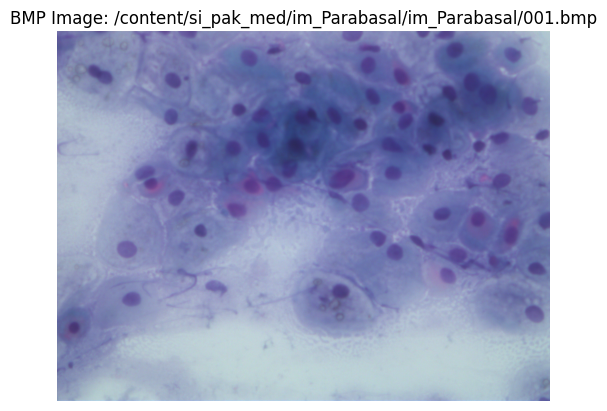

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

def display_bmp_image(file_path):
    try:
        # Open the BMP image
        img = Image.open(file_path)

        # Display the image using matplotlib
        plt.imshow(img)
        plt.title(f'BMP Image: {file_path}')
        plt.axis('off')
        plt.show()

    except IOError:
        print(f"Cannot open BMP file: {file_path}")

# Example usage
# bmp_file_path = '/content/si_pak_med/im_Parabasal/im_Parabasal/075.bmp'
bmp_file_path = '/content/si_pak_med/im_Parabasal/im_Parabasal/001.bmp'
display_bmp_image(bmp_file_path)

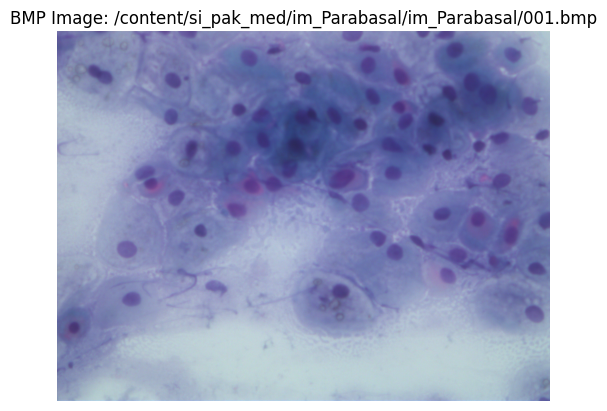

In [5]:
bmp_file_path = '/content/si_pak_med/im_Parabasal/im_Parabasal/001.bmp'
display_bmp_image(bmp_file_path)

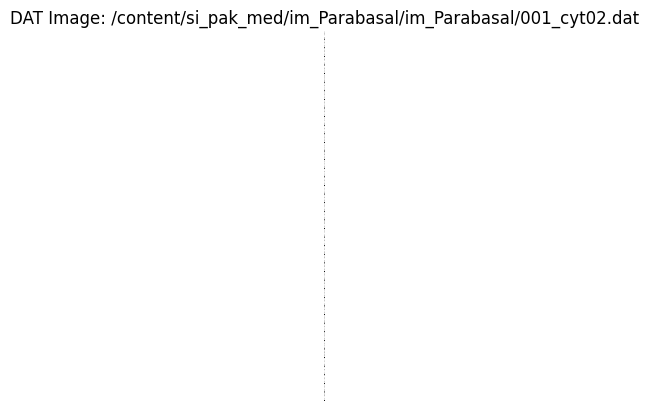

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def display_dat_image(file_path):
    try:
        # Read the raw data from the .dat file
        with open(file_path, 'rb') as f:
            data = f.read()

        # Convert the raw data to a numpy array
        # For grayscale images, use dtype=np.uint8. Adjust if necessary.
        image_array = np.frombuffer(data, dtype=np.uint8)

        # Display the raw data as an image
        # Note: If the data isn't in an image format you can display directly,
        # you will need to adapt this part of the code to handle that format.
        # For demonstration, assuming the raw data is suitable for display.
        img = Image.fromarray(image_array, 'L')  # 'L' mode is for grayscale images

        # Display the image using matplotlib
        plt.imshow(img, cmap='gray')
        plt.title(f'DAT Image: {file_path}')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error with DAT file: {file_path}. Exception: {e}")

# Example usage
dat_file_path = '/content/si_pak_med/im_Parabasal/im_Parabasal/001_cyt02.dat'
display_dat_image(dat_file_path)

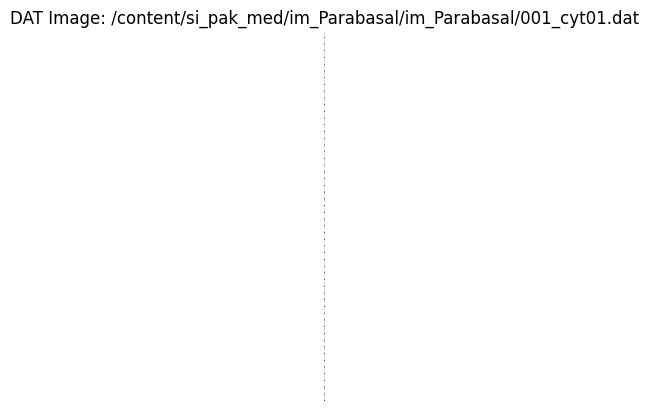

In [7]:
dat_file_path = '/content/si_pak_med/im_Parabasal/im_Parabasal/001_cyt01.dat'
display_dat_image(dat_file_path)

# Creating Folders for Only BMP format

In [8]:
import shutil

def create_bmp_folder(input_folder, output_folder):
    ''' this function enables extraction of the .bmp files from the dataset folder '''
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith('.bmp'):
        # Construct full file path
            file_path = os.path.join(input_folder, filename)
        # Move .bmp file to destination directory
            shutil.move(file_path, output_folder)

create_bmp_folder('/content/si_pak_med/im_Dyskeratotic/im_Dyskeratotic', '/content/si_pak_med/main_im_Dyskeratotic')
create_bmp_folder('/content/si_pak_med/im_Koilocytotic/im_Koilocytotic', '/content/si_pak_med/main_im_Koilocytotic')
create_bmp_folder('/content/si_pak_med/im_Metaplastic/im_Metaplastic', '/content/si_pak_med/main_im_Metaplastic')
create_bmp_folder('/content/si_pak_med/im_Parabasal/im_Parabasal', '/content/si_pak_med/main_im_Parabasal')
create_bmp_folder('/content/si_pak_med/im_Superficial-Intermediate/im_Superficial-Intermediate', '/content/si_pak_med/main_im_Superficial-Intermediate')

# Data Preprocessing

In [10]:
import os
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Defining paths for normal and abnormal categories
normal_dirs = [
    '/content/si_pak_med/main_im_Superficial-Intermediate',
    '/content/si_pak_med/main_im_Metaplastic'
]
abnormal_dirs = [
    '/content/si_pak_med/main_im_Dyskeratotic',
    '/content/si_pak_med/main_im_Koilocytotic',
    '/content/si_pak_med/main_im_Parabasal',
    '/content/si_pak_med/Nig_Positive_cases'
]

# Function to label the dataset as normal and abnormal
def label_dataset(base_dirs, label):
    labeled_images = []
    valid_extensions = (".bmp", ".jpg", ".jpeg", ".png")  # Add supported image formats here
    for dir in base_dirs:
        for image in os.listdir(dir):
            image_path = os.path.join(dir, image)
            if image.lower().endswith(valid_extensions):  # Ensure it's an image with a valid extension
                labeled_images.append((image_path, label))
    return labeled_images

# Labelling datasets (normal = 0, abnormal = 1)
normal_images = label_dataset(normal_dirs, 0)
abnormal_images = label_dataset(abnormal_dirs, 1)

# Combining all images
all_images = normal_images + abnormal_images

# Shuffling the dataset
random.shuffle(all_images)

# Display counts
print(f"Total images: {len(all_images)}")
print(f"Number of normal images: {len(normal_images)}")
print(f"Number of abnormal images: {len(abnormal_images)}")

Total images: 980
Number of normal images: 397
Number of abnormal images: 583


# Delete Irrelevant Folders

In [11]:
for folders in os.listdir('/content/si_pak_med'): # delete folders not starting with main
  if folders.startswith('im'):
    !rm -rf /content/si_pak_med/$folders

# Loading and Transforming Images


In [13]:
from torch.utils.data import random_split, DataLoader
import random
from PIL import Image
from torch.utils.data import Dataset

class CervicalDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, label

# Defining Transformations with additional augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.RandomHorizontalFlip(),                      # Random horizontal flip
    transforms.RandomVerticalFlip(),                        # Random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomRotation(10),                          # Random rotation by 10 degrees
    transforms.ToTensor(),                                  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalization based on ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Creating dataset from the labeled images
dataset = CervicalDataset(all_images, transform=transform)

# Defining split sizes
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

# Splitting the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the sizes
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 686
Validation set size: 147
Test set size: 147


# Pretrained Model using EfficientNet

In [14]:
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

class CervicalDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, label

# Defining Transformations with additional augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.RandomHorizontalFlip(),                      # Random horizontal flip
    transforms.RandomVerticalFlip(),                        # Random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomRotation(10),                          # Random rotation by 10 degrees
    transforms.ToTensor(),                                  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalization based on ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Creating dataset from the labeled images
dataset = CervicalDataset(all_images, transform=transform)

# Defining split sizes
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Splitting the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the sizes
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Load a pre-trained EfficientNet model
model = models.efficientnet_b0(weights='DEFAULT')  # Use weights='DEFAULT' for the latest version
num_ftrs = model.classifier[1].in_features  # Accessing the second layer of the classifier
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Assuming binary classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust based on your needs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_loader.dataset))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

# Test loop
model.eval()
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / len(test_loader.dataset)

# Evaluation metrics
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Training set size: 686
Validation set size: 147
Test set size: 147


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 53.8MB/s]


Epoch [1/10], Train Loss: 0.3874, Train Accuracy: 0.8017, Val Loss: 0.2262, Val Accuracy: 0.9252
Epoch [2/10], Train Loss: 0.2301, Train Accuracy: 0.8907, Val Loss: 0.3056, Val Accuracy: 0.8707
Epoch [3/10], Train Loss: 0.2069, Train Accuracy: 0.9213, Val Loss: 0.1564, Val Accuracy: 0.9388
Epoch [4/10], Train Loss: 0.1474, Train Accuracy: 0.9388, Val Loss: 0.1639, Val Accuracy: 0.9048
Epoch [5/10], Train Loss: 0.1150, Train Accuracy: 0.9650, Val Loss: 0.1171, Val Accuracy: 0.9660
Epoch [6/10], Train Loss: 0.1553, Train Accuracy: 0.9475, Val Loss: 0.2316, Val Accuracy: 0.9116
Epoch [7/10], Train Loss: 0.1839, Train Accuracy: 0.9446, Val Loss: 0.1489, Val Accuracy: 0.9592
Epoch [8/10], Train Loss: 0.1291, Train Accuracy: 0.9592, Val Loss: 0.1323, Val Accuracy: 0.9184
Epoch [9/10], Train Loss: 0.0891, Train Accuracy: 0.9636, Val Loss: 0.1796, Val Accuracy: 0.9184
Epoch [10/10], Train Loss: 0.0535, Train Accuracy: 0.9767, Val Loss: 0.2581, Val Accuracy: 0.9320
Test Accuracy: 0.9456
F1 Scor

In [15]:
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

class CervicalDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, label

# Defining Transformations with additional augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.RandomHorizontalFlip(),                      # Random horizontal flip
    transforms.RandomVerticalFlip(),                        # Random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomRotation(10),                          # Random rotation by 10 degrees
    transforms.ToTensor(),                                  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalization based on ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Creating dataset from the labeled images
dataset = CervicalDataset(all_images, transform=transform)

# Defining split sizes
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Splitting the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the sizes
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Load a pre-trained EfficientNet model
model = models.efficientnet_b0(weights='DEFAULT')  # Use weights='DEFAULT' for the latest version
num_ftrs = model.classifier[1].in_features  # Accessing the second layer of the classifier
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Assuming binary classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Adjust based on your needs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_loader.dataset))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

# Test loop
model.eval()
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / len(test_loader.dataset)

# Evaluation metrics
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Training set size: 686
Validation set size: 147
Test set size: 147
Epoch [1/5], Train Loss: 0.3845, Train Accuracy: 0.8294, Val Loss: 0.2919, Val Accuracy: 0.9252
Epoch [2/5], Train Loss: 0.2689, Train Accuracy: 0.9009, Val Loss: 0.1820, Val Accuracy: 0.9456
Epoch [3/5], Train Loss: 0.1993, Train Accuracy: 0.9169, Val Loss: 0.0942, Val Accuracy: 0.9728
Epoch [4/5], Train Loss: 0.1541, Train Accuracy: 0.9446, Val Loss: 0.2114, Val Accuracy: 0.9252
Epoch [5/5], Train Loss: 0.1475, Train Accuracy: 0.9402, Val Loss: 0.0780, Val Accuracy: 0.9660
Test Accuracy: 0.9524
F1 Score: 0.9522
Precision: 0.9543
Recall: 0.9524
Confusion Matrix:
[[64  6]
 [ 1 76]]


Training set size: 588
Validation set size: 196
Test set size: 196
Epoch [1/10], Train Loss: 0.4548, Train Accuracy: 0.8027, Val Loss: 0.6752, Val Accuracy: 0.8265
Epoch [2/10], Train Loss: 0.2620, Train Accuracy: 0.8861, Val Loss: 0.3177, Val Accuracy: 0.8622
Epoch [3/10], Train Loss: 0.2508, Train Accuracy: 0.8929, Val Loss: 0.1561, Val Accuracy: 0.9235
Epoch [4/10], Train Loss: 0.1878, Train Accuracy: 0.9286, Val Loss: 0.1302, Val Accuracy: 0.9490
Epoch [5/10], Train Loss: 0.1848, Train Accuracy: 0.9388, Val Loss: 0.1764, Val Accuracy: 0.9031
Epoch [6/10], Train Loss: 0.2059, Train Accuracy: 0.9286, Val Loss: 0.3570, Val Accuracy: 0.8827
Epoch [7/10], Train Loss: 0.1813, Train Accuracy: 0.9218, Val Loss: 0.1838, Val Accuracy: 0.9133
Epoch [8/10], Train Loss: 0.1347, Train Accuracy: 0.9490, Val Loss: 0.0872, Val Accuracy: 0.9439
Epoch [9/10], Train Loss: 0.1461, Train Accuracy: 0.9592, Val Loss: 0.2446, Val Accuracy: 0.8929
Epoch [10/10], Train Loss: 0.1337, Train Accuracy: 0.9439, V

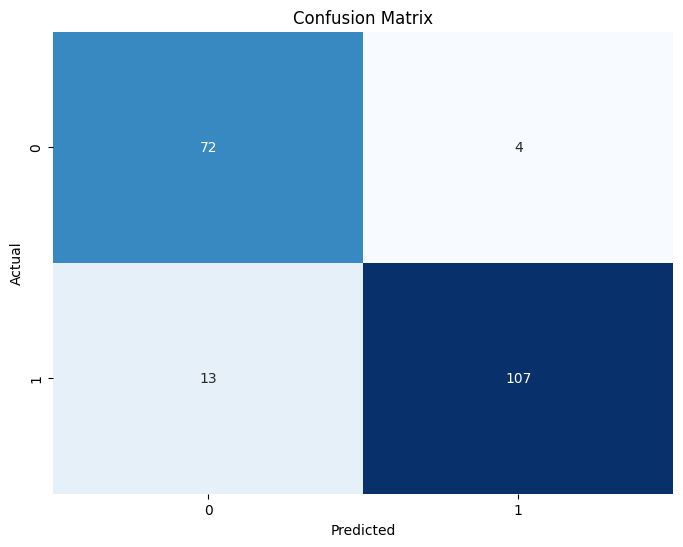

In [17]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Dataset class
class CervicalDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and splits
dataset = CervicalDataset(all_images, transform=transform)
train_size = int(0.6 * len(dataset))  # 60% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # 20% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Model
model = models.efficientnet_b0(weights='DEFAULT')
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

# Training
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))

    model.eval()
    val_loss, correct, all_preds, all_labels = 0.0, 0, [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_loader.dataset))

    scheduler.step(val_losses[-1])
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    early_stopping(val_losses[-1])
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Test accuracy
model.eval()
correct, all_preds, all_labels = 0, [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / len(test_loader.dataset)

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Model Used in Streamlit

Epoch [1/15], Train Loss: 0.4149, Train Accuracy: 0.8090, Val Loss: 0.2304, Val Accuracy: 0.9048
Epoch [2/15], Train Loss: 0.2820, Train Accuracy: 0.8776, Val Loss: 0.2383, Val Accuracy: 0.8980
Epoch [3/15], Train Loss: 0.1967, Train Accuracy: 0.9198, Val Loss: 0.2062, Val Accuracy: 0.8912
Epoch [4/15], Train Loss: 0.1970, Train Accuracy: 0.9300, Val Loss: 0.1693, Val Accuracy: 0.9388
Epoch [5/15], Train Loss: 0.1776, Train Accuracy: 0.9446, Val Loss: 0.1073, Val Accuracy: 0.9558
Epoch [6/15], Train Loss: 0.1412, Train Accuracy: 0.9373, Val Loss: 0.1468, Val Accuracy: 0.9388
Epoch [7/15], Train Loss: 0.1062, Train Accuracy: 0.9592, Val Loss: 0.0998, Val Accuracy: 0.9592
Epoch [8/15], Train Loss: 0.0870, Train Accuracy: 0.9723, Val Loss: 0.0735, Val Accuracy: 0.9660
Epoch [9/15], Train Loss: 0.0502, Train Accuracy: 0.9854, Val Loss: 0.1061, Val Accuracy: 0.9660
Epoch [10/15], Train Loss: 0.0588, Train Accuracy: 0.9694, Val Loss: 0.1110, Val Accuracy: 0.9626
Epoch [11/15], Train Loss: 0.

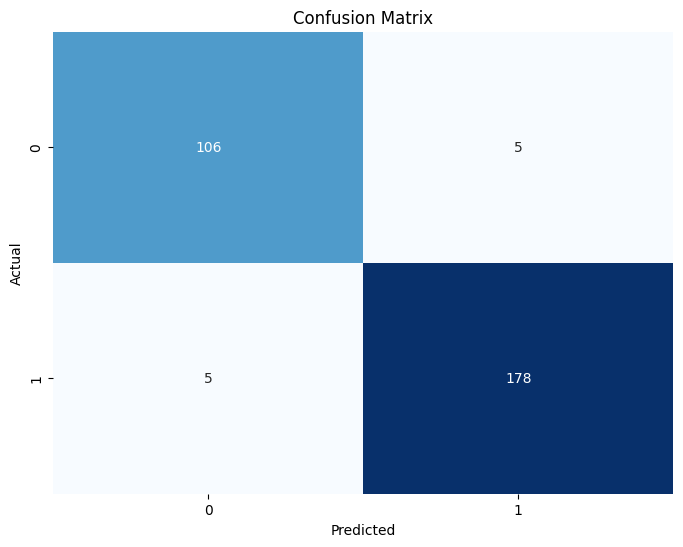

In [24]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

class CervicalDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Additional Augmentation Techniques
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating dataset from the labeled images
dataset = CervicalDataset(all_images, transform=transform)

# Splitting dataset
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load EfficientNet
model = models.efficientnet_b0(weights='DEFAULT')
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # Use AdamW

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training loop with early stopping
num_epochs = 15  # Increased epochs
early_stopping = EarlyStopping(patience=5)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_loader.dataset))

    # Reduce learning rate using cosine annealing
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Check early stopping
    early_stopping(val_losses[-1])
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Test accuracy
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Assuming you have a test dataset

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Evaluation metrics
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ResNet-50

Epoch [1/15], Train Loss: 0.5271, Train Accuracy: 0.7638, Val Loss: 2.1533, Val Accuracy: 0.7041
Epoch [2/15], Train Loss: 0.3442, Train Accuracy: 0.8717, Val Loss: 0.7618, Val Accuracy: 0.8469
Epoch [3/15], Train Loss: 0.2223, Train Accuracy: 0.9155, Val Loss: 0.5505, Val Accuracy: 0.8707
Epoch [4/15], Train Loss: 0.2836, Train Accuracy: 0.9038, Val Loss: 0.3544, Val Accuracy: 0.9048
Epoch [5/15], Train Loss: 0.2466, Train Accuracy: 0.9082, Val Loss: 0.2340, Val Accuracy: 0.9048
Epoch [6/15], Train Loss: 0.2114, Train Accuracy: 0.9227, Val Loss: 0.2042, Val Accuracy: 0.9286
Epoch [7/15], Train Loss: 0.1587, Train Accuracy: 0.9388, Val Loss: 0.1610, Val Accuracy: 0.9456
Epoch [8/15], Train Loss: 0.1096, Train Accuracy: 0.9636, Val Loss: 0.1652, Val Accuracy: 0.9354
Epoch [9/15], Train Loss: 0.1480, Train Accuracy: 0.9446, Val Loss: 0.1593, Val Accuracy: 0.9218
Epoch [10/15], Train Loss: 0.1353, Train Accuracy: 0.9519, Val Loss: 0.1807, Val Accuracy: 0.9354
Epoch [11/15], Train Loss: 0.

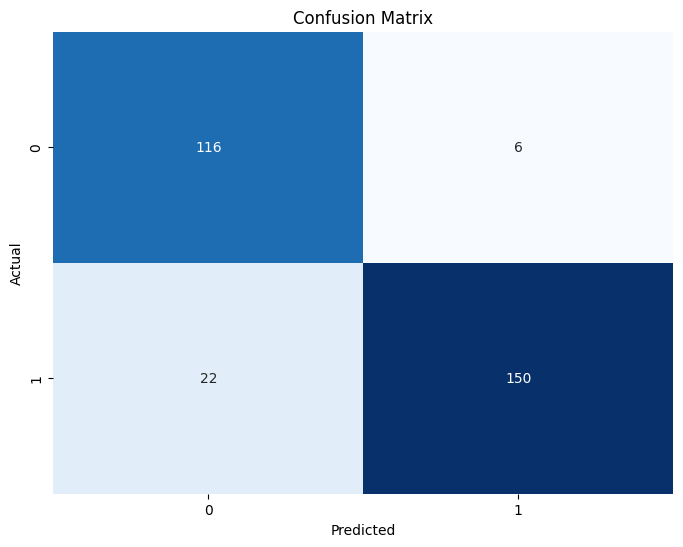

In [21]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

class CervicalDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Additional Augmentation Techniques
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating dataset from the labeled images
dataset = CervicalDataset(all_images, transform=transform)

# Splitting dataset
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load ResNet50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification (2 classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # Use AdamW

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training loop with early stopping
num_epochs = 15  # Increased epochs
early_stopping = EarlyStopping(patience=5)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_loader.dataset))

    # Reduce learning rate using cosine annealing
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Check early stopping
    early_stopping(val_losses[-1])
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Test accuracy
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Assuming you have a test dataset

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Evaluation metrics
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Epoch [1/10], Train Loss: 0.6056, Train Accuracy: 0.7376, Val Loss: 30.2241, Val Accuracy: 0.7109
Epoch [2/10], Train Loss: 0.3967, Train Accuracy: 0.8309, Val Loss: 1.4788, Val Accuracy: 0.6871
Epoch [3/10], Train Loss: 0.3022, Train Accuracy: 0.8907, Val Loss: 0.5660, Val Accuracy: 0.7857
Epoch [4/10], Train Loss: 0.2756, Train Accuracy: 0.8907, Val Loss: 0.5005, Val Accuracy: 0.8810
Epoch [5/10], Train Loss: 0.3020, Train Accuracy: 0.8848, Val Loss: 0.3169, Val Accuracy: 0.8605
Epoch [6/10], Train Loss: 0.2759, Train Accuracy: 0.9067, Val Loss: 0.2381, Val Accuracy: 0.9116
Epoch [7/10], Train Loss: 0.2095, Train Accuracy: 0.9315, Val Loss: 0.2761, Val Accuracy: 0.9048
Epoch [8/10], Train Loss: 0.1703, Train Accuracy: 0.9431, Val Loss: 0.1794, Val Accuracy: 0.9286
Epoch [9/10], Train Loss: 0.1550, Train Accuracy: 0.9359, Val Loss: 0.2074, Val Accuracy: 0.9150
Epoch [10/10], Train Loss: 0.1291, Train Accuracy: 0.9592, Val Loss: 0.1963, Val Accuracy: 0.9150
Test Accuracy: 0.9643
F1 Sco

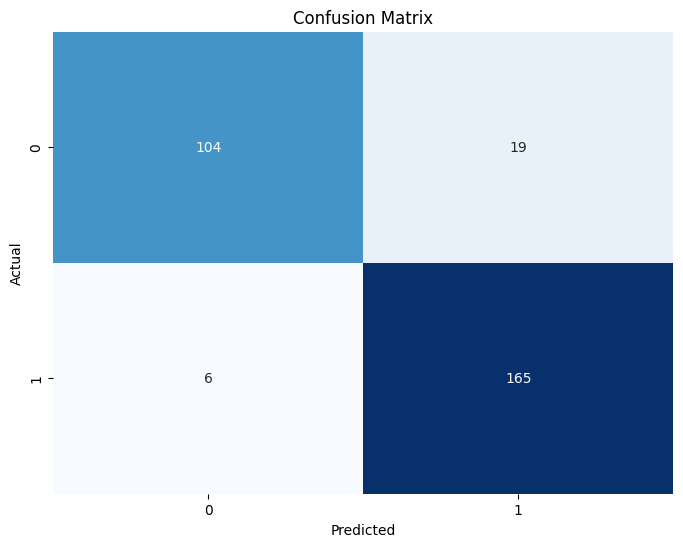

In [23]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

class CervicalDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Additional Augmentation Techniques
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating dataset from the labeled images
dataset = CervicalDataset(all_images, transform=transform)

# Splitting dataset
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load ResNet50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification (2 classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # Use AdamW

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training loop with early stopping
num_epochs = 10  # Increased epochs
early_stopping = EarlyStopping(patience=5)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_loader.dataset))

    # Reduce learning rate using cosine annealing
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Check early stopping
    early_stopping(val_losses[-1])
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Test accuracy
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Assuming you have a test dataset

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Evaluation metrics
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Streamlit

In [25]:
!pip install torch torchvision streamlit Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [26]:
# Save the model
torch.save(model.state_dict(), 'cervical_model.pth')

In [32]:
import torch
import torch.nn as nn
from torchvision import models

# Load the model architecture
def load_model(model_path, device):
    model = models.efficientnet_b0(weights='DEFAULT')  # Load the same architecture as used for training
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust the classifier layer for 2 output classes
    model = model.to(device)  # Move model to the appropriate device

    # Load the model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    return model

# Image prediction function
from PIL import Image
from torchvision import transforms

def predict_image(image_path, model, device):
    # Define the image transformations (should match the training augmentations)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Open the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move image to the correct device

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()

    return 'Abnormal' if class_idx == 1 else 'Normal'

In [33]:
# Test the prediction function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/cervical_model.pth'  # Update with your model path
model = load_model(model_path=model_path, device=device)  # Load the trained model

image_path = '/content/si_pak_med/Nig_Positive_cases/0001.jpg'  # Path to the image you want to predict

prediction = predict_image(image_path, model, device)
print(f"The image is: {prediction}")

The image is: Abnormal


<ipython-input-32-44a1f4f640ee>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [35]:
# Test the prediction function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/cervical_model.pth'  # Update with your model path
model = load_model(model_path=model_path, device=device)  # Load the trained model

image_path = '/content/si_pak_med/main_im_Superficial-Intermediate/005.bmp'  # Path to the image you want to predict

prediction = predict_image(image_path, model, device)
print(f"The image is: {prediction}")

<ipython-input-32-44a1f4f640ee>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


The image is: Normal


In [43]:
import streamlit as st
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn

# Function to load the trained model
def load_model(model_path='best_model.pth'):
    model = models.efficientnet_b0(weights='DEFAULT')
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # Assuming binary classification (normal vs abnormal)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model

# Function to preprocess the image
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Prediction function
def predict_image(image, model):
    image = preprocess_image(image)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return "Normal" if predicted.item() == 0 else "Abnormal"

# Streamlit interface
st.title("Cervical Image Classifier")
st.write("Upload an image to classify it as Normal or Abnormal.")

uploaded_image = st.file_uploader("Choose an image...", type="jpg")

if uploaded_image is not None:
    image = Image.open(uploaded_image)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")

    model = load_model(model_path='best_model.pth')  # Load the trained model
    prediction = predict_image(image, model)
    st.write(f"Prediction: The image is {prediction}")

2024-11-27 09:21:49.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-27 09:21:49.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-27 09:21:49.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-27 09:21:49.106 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-27 09:21:49.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-27 09:21:49.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-27 09:21:49.111 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-27 09:21:49.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [47]:
# Save the Streamlit code as app.py
streamlit_code = '''
import streamlit as st
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn

# Check if CUDA (GPU) is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load the trained model
def load_model(model_path='best_model.pth'):
    model = models.efficientnet_b0(weights='DEFAULT')
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # Assuming binary classification (normal vs abnormal)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model

# Function to preprocess the image
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Prediction function
def predict_image(image, model):
    image = preprocess_image(image)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return "Normal" if predicted.item() == 0 else "Abnormal"

# Streamlit interface
st.title("Cervical Image Classifier")
st.write("Upload an image to classify it as Normal or Abnormal.")

uploaded_image = st.file_uploader("Choose an image...", type="jpg")

if uploaded_image is not None:
    image = Image.open(uploaded_image)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")

    model = load_model(model_path='/content/cervical_model.pth')  # Load the trained model
    prediction = predict_image(image, model)
    st.write(f"Prediction: The image is {prediction}")
'''

# Write the code to a Python file (app.py)
with open('/content/app.py', 'w') as f:
    f.write(streamlit_code)

In [39]:
!ngrok authtoken 2pQWJgLbGjUDtM4yOypoPYNzgkb_6x6L5v6djxmCcK9BNERyJ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [48]:
from pyngrok import ngrok
import os

# Run Streamlit app in the background
os.system('streamlit run /content/app.py &')

# Set up a tunnel to make Streamlit accessible over the internet
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")

Streamlit app is live at: NgrokTunnel: "https://2801-34-125-152-147.ngrok-free.app" -> "http://localhost:8501"
